<div style="float:left">
    <h1 style="width:800px">Reproducible processing for design storm sequence</h1>
    <h3 style="width:600px">CASA0012: MSc SDSV Dissertation</h3>
    <h3 style="width:600px">Author: Haisu Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

This part of notebook aims to produce the 1-hour rainfall sequence of 1% AEP risk. The remaining preprocessing will be condcuted in QGIS. The *urls* of dataset associated to hydrodynamic modelling will be outlined.

In [2]:
!pip install mikeio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.3/186.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.2/927.2 kB 9.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import time
import mikeio
from mikeio import ItemInfo, EUMType, EUMUnit
import seaborn as sns
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import networkx as nx

In [40]:
dirs = 'Outputs'
if not os.path.exists(dirs):
    os.makedirs(dirs)

## Hydrograph estabilish

In [4]:
# Credit: https://github.com/rywm-dhi/storms
def getIntensity(duration, A, B, C):
    """Calculate intensity for specified duration given IDF parameters A, B, and C.

    Args:
        duration: duration to calculate intensity for. Unit: minutes
        A: constant A in equation i = A / (duration + B)**C.
        B: constant B in equation i = A / (duration + B)**C.
        C: constant C in equation i = A / (duration + B)**C.

    Returns:
        Returns intensity in mm/hr.

    """
    return A / (duration + B) ** C


def getABC(durations, intensities, priority_durations=[]):
    """Calculate IDF ABC parameters based on set of durations and intensities.

    Args:
        durations: an array of the durations. Unit: minutes
        intensities: an array of the intensities. Unit: mm/hr

    Returns:
        Returns A, B, C, r_squared as a tuple.

    """

    # Priority durations
    if len(priority_durations) > 0:
        sigma = durations.apply(lambda x: 0.05 if x in priority_durations else 0.25)
    else:
        sigma = None

    # get A, B, C
    with warnings.catch_warnings():
        # curve_fit throws a warning because it tries negative exponents ... ignore it
        warnings.simplefilter("ignore")
        popt, pcov = curve_fit(getIntensity, durations, intensities, sigma=sigma)

    A, B, C = popt

    # calculate r squared
    residuals = intensities - getIntensity(durations, A, B, C)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((intensities - np.mean(intensities)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return (A, B, C, r_squared)


def ib(tb, r, a, b, c):
    """Chicago design storm equation - intensity before peak.
        Helper for i function.

    Args:
        tb: time before peak in minutes (measured from peak towards beginning)
        r: time to peak ratio (peak time divided by total duration)
        a: IDF A parameter - can be calculated from getABC
        b: IDF B parameter - can be calculated from getABC
        c: IDF C parameter  - can be calculated from getABC

    Returns:
        Returns intensity in mm/hr.

    """
    return a * ((1 - c) * tb / r + b) / ((tb / r) + b) ** (c + 1)


def ia(ta, r, a, b, c):
    """Chicago design storm equation - intensity after peak. Helper for i function.

    Args:
        ta: time after peak in minutes (measured from peak towards end)
        r: time to peak ratio (peak time divided by total duration)
        a: IDF A parameter - can be calculated from getABC
        b: IDF B parameter - can be calculated from getABC
        c: IDF C parameter  - can be calculated from getABC

    Returns:
        Returns intensity in mm/hr.

    """
    return a * ((1 - c) * ta / (1 - r) + b) / ((ta / (1 - r)) + b) ** (c + 1)


def i(t, T, r, a, b, c):
    """Chicago design storm equation - intensity. Uses ia and ib functions.

    Args:
        t: time in minutes from storm eginning
        T: total storm duration in minutes
        r: time to peak ratio (peak time divided by total duration)
        a: IDF A parameter - can be calculated from getABC
        b: IDF B parameter - can be calculated from getABC
        c: IDF C parameter  - can be calculated from getABC

    Returns:
        Returns intensity in mm/hr.

    """
    if t < T * r:
        return ib(T * r - t, r, a, b, c)
    elif t > T * r:
        return ia(t - T * r, r, a, b, c)
    else:
        # Should be infinity, but this does the job
        return 1000


def createCDS(T, r, dt, a, b, c):
    """Makes a chicago design storm.

    Args:
        T: total storm duration in minutes
        r: time to peak ration (peak time divided by total duration)
        dt: time step in minutes
        a: IDF A parameter - can be calculated from getABC
        b: IDF B parameter - can be calculated from getABC
        c: IDF C parameter  - can be calculated from getABC

    Returns:
        Returns tuple of (dt, array of intensities).

    """

    # make time axis
    times = np.arange(0 - dt * r, T - dt * r, dt)

    # determine time step averaged intensities
    values = [0]
    for time in times:
        values.append(quad(i, time, time + dt, args=(T, r, a, b, c))[0] / dt)

    df = pd.DataFrame(
        {"Intensity": values},
        index=pd.date_range("2000-1-1", periods=len(times) + 1, freq=f"{dt}min"),
    )
    df.index.name = "Time"

    return df


Design Rainfall accessed from: http://www.bom.gov.au/water/designRainfalls/revised-ifd/?multipoint

Latitude: -37.82
Longitude: 144.96

In [18]:
df = pd.read_csv('Resources/depths_-37.82_144.96_all_design.csv',header=9)

In [19]:
df.head(10)

,Duration,Duration in min,12EY,6EY,4EY,3EY,2EY,63.20%,50%,0.5EY,20%,0.2EY,10%,5%,2%,1%,1 in 200,1 in 500,1 in 1000,1 in 2000
0,1 min,1,0.571,0.659,0.825,0.954,1.15,1.55,1.74,1.93,2.40,2.45,2.91,3.46,4.27,4.96,5.71,6.68,7.47,8.32
1,2 min,2,1.000,1.150,1.440,1.660,1.99,2.65,2.95,3.28,3.98,4.06,4.78,5.63,6.84,7.87,8.91,10.30,11.40,12.60
2,3 min,3,1.350,1.560,1.940,2.230,2.69,3.56,3.97,4.41,5.38,5.49,6.47,7.63,9.29,10.70,12.20,14.10,15.70,17.40
3,4 min,4,1.640,1.900,2.360,2.720,3.27,4.34,4.85,5.38,6.60,6.74,7.95,9.40,11.50,13.30,15.20,17.60,19.70,21.80
4,5 min,5,1.900,2.190,2.730,3.150,3.78,5.00,5.60,6.22,7.67,7.83,9.26,11.00,13.50,15.60,17.90,20.80,23.20,25.80
5,10 min,10,2.860,3.290,4.080,4.690,5.62,7.42,8.35,9.27,11.60,11.80,14.10,16.70,20.70,24.10,27.80,32.50,36.40,40.70
6,15 min,15,3.540,4.050,5.010,5.740,6.86,9.04,10.20,11.30,14.20,14.40,17.20,20.50,25.40,29.60,34.20,40.00,44.80,50.00
7,20 min,20,4.070,4.650,5.720,6.550,7.81,10.30,11.60,12.80,16.10,16.40,19.50,23.30,28.80,33.60,38.70,45.30,50.70,56.60
8,25 min,25,4.510,5.140,6.310,7.210,8.59,11.30,12.70,14.10,17.60,17.90,21.30,25.40,31.50,36.70,42.20,49.40,55.20,61.50
9,30 min,30,4.880,5.560,6.820,7.780,9.25,12.10,13.60,15.10,18.80,19.20,22.80,27.20,33.60,39.20,45.10,52.60,58.80,65.50


In [24]:
df['Duration_in_hour'] = df.iloc[:,1] / 60

In [27]:
df2 = df[['Duration in min','Duration_in_hour']].copy()

In [29]:
df2['intensity (mm/hr)'] = df['1%'] / df2['Duration_in_hour']

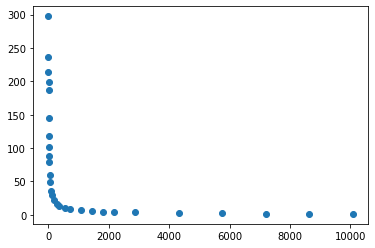

In [31]:
durations = df2["Duration in min"]
intensities = df2["intensity (mm/hr)"]

plt.scatter(durations, intensities)


A = 858.0814272526551
B = 3.946554460091999
C = 0.6936267491650622
R-squared = 0.9967038778742779


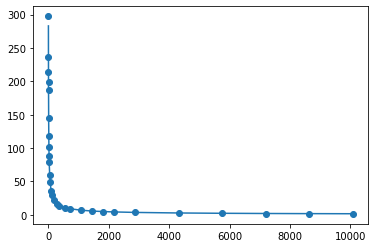

In [36]:
A, B, C, r2 = getABC(durations, intensities, priority_durations=[120])
plt.scatter(durations, intensities)
plt.plot(durations, getIntensity(durations, A, B, C))
print("A = {0}".format(A))
print("B = {0}".format(B))
print("C = {0}".format(C))
print("R-squared = {0}".format(r2))

<AxesSubplot:xlabel='Time'>

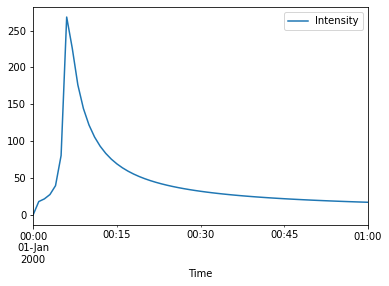

In [37]:
storm = createCDS(60, 0.087, 1, A, B, C)
storm.plot()

In [38]:
storm['depth'] = storm['Intensity']/60*1

In [39]:
storm

,Intensity,depth
Time,,
2000-01-01 00:00:00,0.000000,0.000000
2000-01-01 00:01:00,17.890030,0.298167
2000-01-01 00:02:00,21.470845,0.357847
2000-01-01 00:03:00,27.397732,0.456629
2000-01-01 00:04:00,39.440644,0.657344
...,...,...
2000-01-01 00:56:00,17.913971,0.298566
2000-01-01 00:57:00,17.644055,0.294068
2000-01-01 00:58:00,17.383626,0.289727


In [41]:
storm.to_csv('Outputs/stormseries_1AEP.csv')

In [42]:
timelabel = np.arange(0,61,1)

In [43]:
np.linspace(0,60,11)

array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.])

In [ ]:
timelabel

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60])

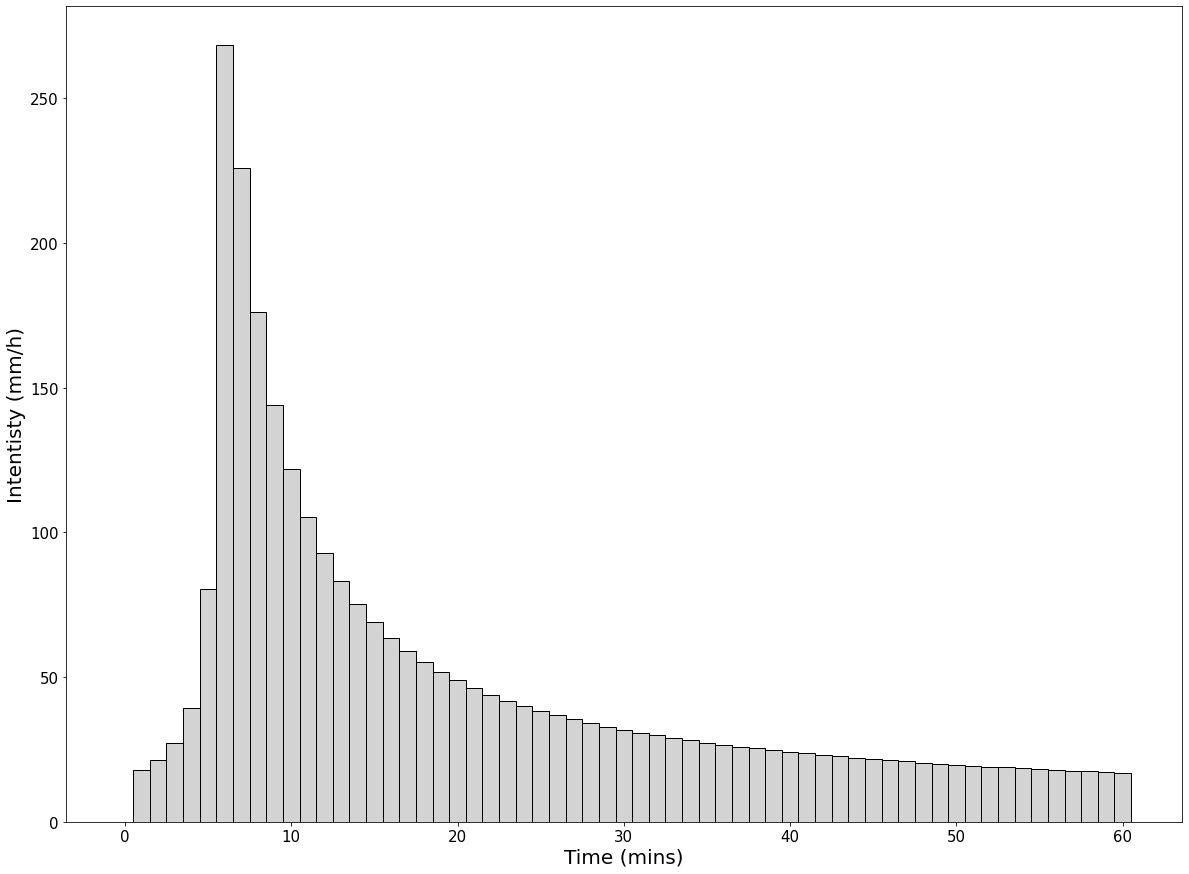

In [45]:
fig, ax=plt.subplots(figsize=(20,15))
ax.bar(range(len(storm)), storm['Intensity'],width=1, color='lightgrey',edgecolor='black')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Time (mins)',fontsize=20)
plt.ylabel('Intentisty (mm/h)',fontsize=20)
plt.savefig('Outputs/Hydrograph.png')

## Links of datasets for hydrodynmaic modelling

URLs for the datasets are all presented below. For datasets in zip and csv, a process of downloading and unzipping will begin if run the corresponding codes. For datasets of raster and gdb, links are provided but required a manual access.

### List for Access

[1]&emsp;[10m DEM for the City of Melbourne](https://elevation.fsdf.org.au/)

[2]&emsp;[Sentinel-2 10m land cover](https://www.arcgis.com/home/item.html?id=d3da5dd386d140cf93fc9ecbf8da5e31)

[3]&emsp;[Surface Hydrology Polygons](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/83134)


In [47]:
URL_MunicipalBoundary = 'https://data.melbourne.vic.gov.au/api/geospatial/ck33-yh8z?method=export&format=Shapefile'

URL_Building = 'https://data.melbourne.vic.gov.au/api/geospatial/pv8y-ihee?method=export&format=Shapefile'

URL_Soil = 'https://data.melbourne.vic.gov.au/api/geospatial/t3zn-qgfx?method=export&format=Shapefile'

URL_Road = 'https://data.melbourne.vic.gov.au/api/geospatial/su97-b2at?method=export&format=Shapefile'

URL_Street = 'https://data.melbourne.vic.gov.au/api/geospatial/2x56-ai8r?method=export&format=Shapefile'

URL_Drainpipes = 'https://data.melbourne.vic.gov.au/api/geospatial/3bff-vaa5?method=export&format=Shapefile'

CSV_URL_Strompits = 'https://data.melbourne.vic.gov.au/api/views/psq9-yz4x/rows.csv?accessType=DOWNLOAD'

ZipList = [URL_MunicipalBoundary,URL_Building,URL_Soil,URL_Road,URL_Street,URL_Drainpipes]

In [ ]:
import requests, zipfile, io

dirs = 'Resources/Raw'
if not os.path.exists(dirs):
    os.makedirs(dirs)

for url in ZipList:
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("Resources/Raw")